# Deteksi Phishing dengan CNN + LSTM Hybrid Model

## Penelitian Tugas Akhir
**Deteksi Phishing menggunakan Deep Learning: Arsitektur Hybrid CNN-LSTM**

### Deskripsi Proyek
Notebook ini mengimplementasikan model deep learning hybrid yang menggabungkan Convolutional Neural Network (CNN) dan Long Short-Term Memory (LSTM) untuk mendeteksi URL phishing berdasarkan fitur-fitur URL.

### Arsitektur Model
- **CNN Layer**: Ekstraksi fitur lokal dari data URL
- **LSTM Layer**: Menangkap dependensi temporal dan sekuensial
- **Dense Layer**: Klasifikasi akhir (Legitimate vs Phishing)

### Dataset
Dataset berisi 247,952 sampel dengan 41 fitur berbasis URL dan 1 target (Type: 0=Legitimate, 1=Phishing)

## 1. Import Libraries dan Setup Environment

In [ ]:
# Import library untuk data processing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils import class_weight

# Import TensorFlow dan Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.optimizers import Adam

# Import library tambahan
import warnings
import os
from datetime import datetime

# Settings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Set random seed untuk reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Check TensorFlow version dan GPU
print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")
print(f"Keras Version: {keras.__version__}")

## 2. Load dan Eksplorasi Dataset

In [13]:
# Load dataset
dataset_path = 'dataset/Dataset.csv'
df = pd.read_csv(dataset_path)

# Informasi dasar dataset
print("="*60)
print("INFORMASI DATASET")
print("="*60)
print(f"Jumlah sampel: {len(df)}")
print(f"Jumlah fitur: {len(df.columns) - 1}")
print(f"Ukuran dataset: {df.shape}")
print(f"\nNama kolom:\n{df.columns.tolist()}")
print(f"\nMissing values:\n{df.isnull().sum().sum()}")

# Display beberapa baris pertama
print("\n" + "="*60)
print("PREVIEW DATA")
print("="*60)
df.head(10)

INFORMASI DATASET
Jumlah sampel: 247950
Jumlah fitur: 41
Ukuran dataset: (247950, 42)

Nama kolom:
['Type', 'url_length', 'number_of_dots_in_url', 'having_repeated_digits_in_url', 'number_of_digits_in_url', 'number_of_special_char_in_url', 'number_of_hyphens_in_url', 'number_of_underline_in_url', 'number_of_slash_in_url', 'number_of_questionmark_in_url', 'number_of_equal_in_url', 'number_of_at_in_url', 'number_of_dollar_in_url', 'number_of_exclamation_in_url', 'number_of_hashtag_in_url', 'number_of_percent_in_url', 'domain_length', 'number_of_dots_in_domain', 'number_of_hyphens_in_domain', 'having_special_characters_in_domain', 'number_of_special_characters_in_domain', 'having_digits_in_domain', 'number_of_digits_in_domain', 'having_repeated_digits_in_domain', 'number_of_subdomains', 'having_dot_in_subdomain', 'having_hyphen_in_subdomain', 'average_subdomain_length', 'average_number_of_dots_in_subdomain', 'average_number_of_hyphens_in_subdomain', 'having_special_characters_in_subdomain

,Type,url_length,number_of_dots_in_url,having_repeated_digits_in_url,number_of_digits_in_url,number_of_special_char_in_url,number_of_hyphens_in_url,number_of_underline_in_url,number_of_slash_in_url,number_of_questionmark_in_url,...,having_digits_in_subdomain,number_of_digits_in_subdomain,having_repeated_digits_in_subdomain,having_path,path_length,having_query,having_fragment,having_anchor,entropy_of_url,entropy_of_domain
0,0,37,2,0,0,8,0,0,5,0,...,0,0,1,0,3,0,0,0,4.010412,2.751629
1,1,70,5,0,0,12,0,0,6,0,...,0,0,1,0,4,0,0,0,4.089470,3.532573
2,0,42,2,0,6,8,0,0,3,1,...,0,0,1,0,1,1,0,0,4.386016,3.344698
3,0,46,2,0,0,7,0,0,4,0,...,0,0,1,0,2,0,0,0,4.221947,3.189898
4,0,51,3,0,0,9,0,0,5,0,...,0,0,1,0,3,0,0,0,4.103538,2.952820
5,0,51,1,0,0,9,2,0,5,0,...,0,0,1,0,3,0,0,0,4.136372,3.454822
6,0,86,3,0,0,14,6,0,4,0,...,0,0,1,0,2,0,0,0,4.299706,3.101881
7,1,64,1,0,1,10,0,0,7,0,...,0,0,1,0,5,0,0,0,4.366479,3.281036
8,0,54,2,0,0,8,0,1,4,0,...,0,0,1,0,2,0,0,0,4.291266,3.854286
9,0,44,2,0,0,8,1,0,4,0,...,0,0,1,0,2,0,0,0,4.362507,3.521641


In [3]:
# Statistik deskriptif
print("="*60)
print("STATISTIK DESKRIPTIF")
print("="*60)
df.describe()

STATISTIK DESKRIPTIF


,Type,url_length,number_of_dots_in_url,having_repeated_digits_in_url,number_of_digits_in_url,number_of_special_char_in_url,number_of_hyphens_in_url,number_of_underline_in_url,number_of_slash_in_url,number_of_questionmark_in_url,...,having_digits_in_subdomain,number_of_digits_in_subdomain,having_repeated_digits_in_subdomain,having_path,path_length,having_query,having_fragment,having_anchor,entropy_of_url,entropy_of_domain
count,247950.000000,247950.000000,247950.000000,247950.000000,247950.000000,247950.000000,247950.000000,247950.000000,247950.000000,247950.000000,...,247950.000000,247950.000000,247950.0,247950.0,247950.000000,247950.000000,247950.000000,247950.000000,247950.000000,247950.000000
mean,0.481585,58.358197,2.894075,0.162351,4.366070,10.303218,0.600867,0.204049,4.784533,0.159911,...,0.064529,0.224013,1.0,0.0,2.606977,0.126501,0.002303,0.000944,4.257222,3.389839
std,0.499662,29.764620,1.690970,0.368773,9.579032,4.718381,1.235599,0.653502,1.812574,0.449506,...,0.245694,1.276447,0.0,0.0,1.636938,0.332414,0.047933,0.030706,0.328098,0.376361
min,0.000000,12.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,2.000000,0.000000,...,0.000000,0.000000,1.0,0.0,0.000000,0.000000,0.000000,0.000000,2.648939,1.386274
25%,0.000000,39.000000,2.000000,0.000000,0.000000,7.000000,0.000000,0.000000,4.000000,0.000000,...,0.000000,0.000000,1.0,0.0,2.000000,0.000000,0.000000,0.000000,4.038910,3.180833
50%,0.000000,49.000000,3.000000,0.000000,0.000000,9.000000,0.000000,0.000000,4.000000,0.000000,...,0.000000,0.000000,1.0,0.0,2.000000,0.000000,0.000000,0.000000,4.208298,3.392747
75%,1.000000,69.000000,3.000000,0.000000,4.000000,11.000000,1.000000,0.000000,5.000000,0.000000,...,0.000000,0.000000,1.0,0.0,3.000000,0.000000,0.000000,0.000000,4.428036,3.606937
max,1.000000,191.000000,28.000000,1.000000,144.000000,75.000000,23.000000,47.000000,30.000000,17.000000,...,1.000000,44.000000,1.0,0.0,28.000000,1.000000,1.000000,1.000000,5.866327,4.957323


DISTRIBUSI KELAS
Legitimate (0): 128541 (51.84%)
Phishing (1): 119409 (48.16%)


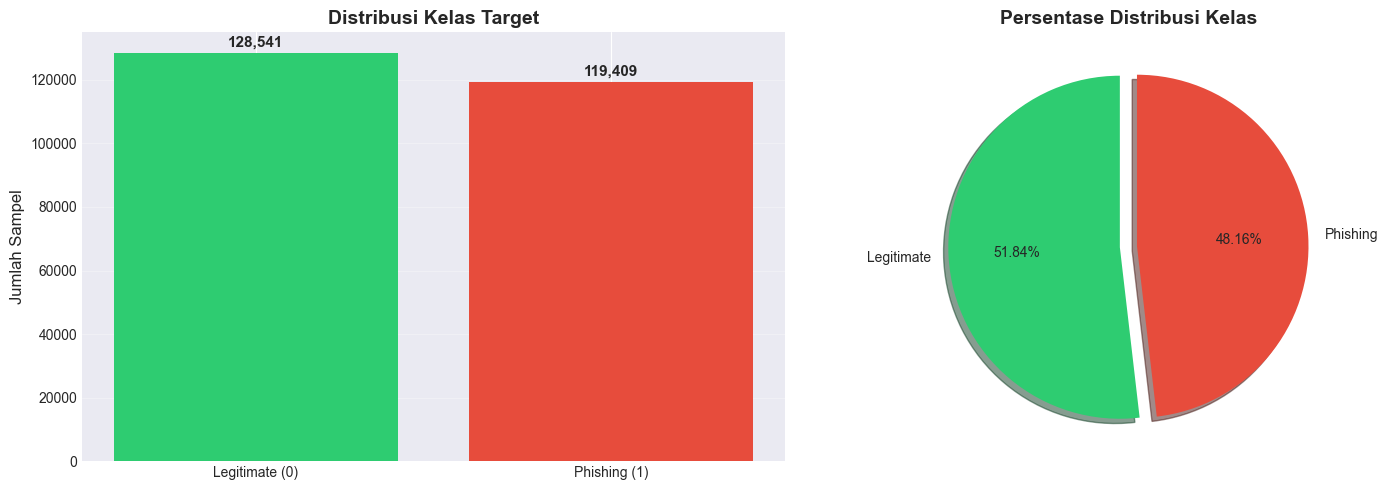


Rasio Imbalance: 1.08x


In [4]:
# Analisis distribusi kelas
print("="*60)
print("DISTRIBUSI KELAS")
print("="*60)

class_counts = df['Type'].value_counts()
print(f"Legitimate (0): {class_counts[0]} ({class_counts[0] / len(df) * 100:.2f}%)")
print(f"Phishing (1): {class_counts[1]} ({class_counts[1] / len(df) * 100:.2f}%)")

# Visualisasi distribusi kelas
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Bar plot
axes[0].bar(['Legitimate (0)', 'Phishing (1)'], class_counts.values, color=['#2ecc71', '#e74c3c'])
axes[0].set_ylabel('Jumlah Sampel', fontsize=12)
axes[0].set_title('Distribusi Kelas Target', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Tambahkan nilai di atas bar
for i, v in enumerate(class_counts.values):
    axes[0].text(i, v + 1000, f'{v:,}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Pie chart
colors = ['#2ecc71', '#e74c3c']
explode = (0.05, 0.05)
axes[1].pie(class_counts.values, labels=['Legitimate', 'Phishing'], autopct='%1.2f%%',
            colors=colors, explode=explode, shadow=True, startangle=90)
axes[1].set_title('Persentase Distribusi Kelas', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Check balance
imbalance_ratio = class_counts.max() / class_counts.min()
print(f"\nRasio Imbalance: {imbalance_ratio:.2f}x")
if imbalance_ratio > 1.5:
    print("⚠️ Dataset tidak seimbang. Class weights akan digunakan saat training.")

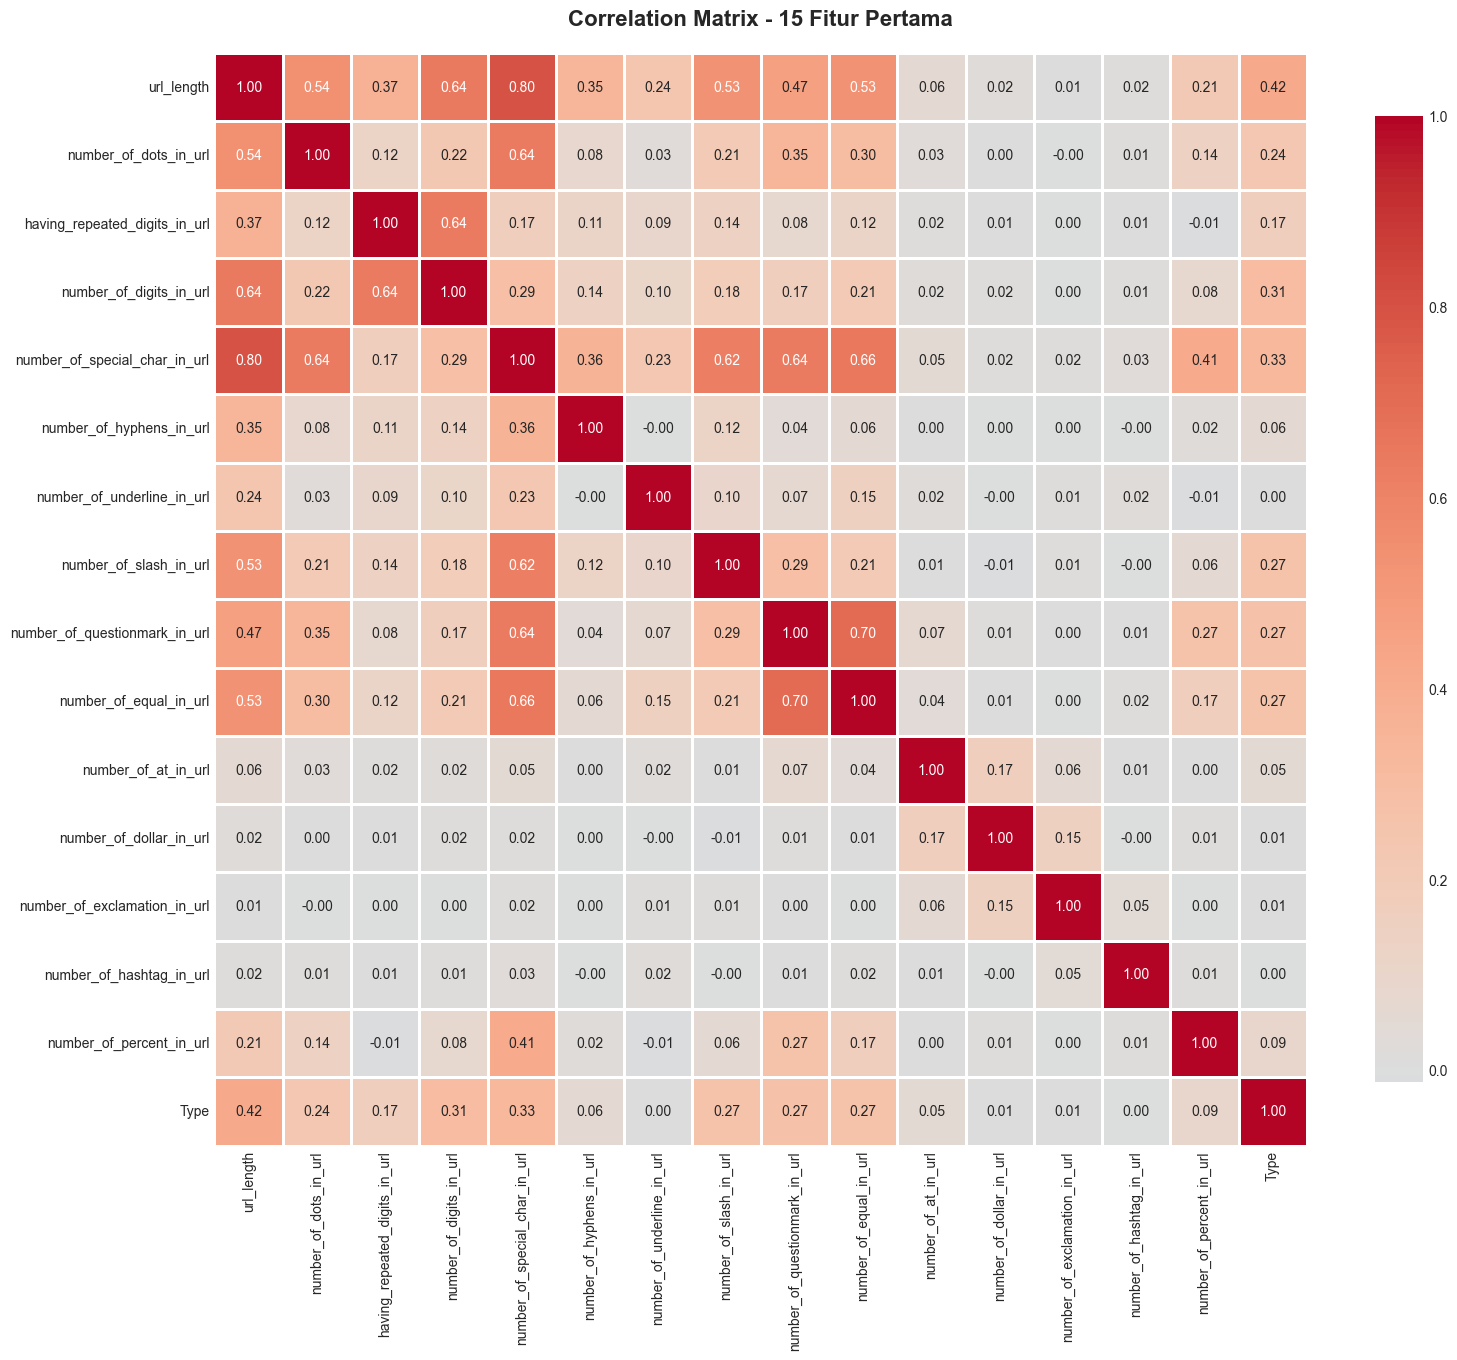


TOP 10 FITUR DENGAN KORELASI TERTINGGI KE TARGET
url_length                       0.421119
entropy_of_url                   0.360472
average_subdomain_length         0.347888
number_of_special_char_in_url    0.333391
number_of_digits_in_domain       0.310394
number_of_digits_in_url          0.310394
having_digits_in_domain          0.288923
number_of_questionmark_in_url    0.269550
number_of_slash_in_url           0.266817
entropy_of_domain                0.266425
Name: Type, dtype: float64


In [5]:
# Visualisasi korelasi beberapa fitur penting
feature_cols = df.columns[1:]  # Semua kolom kecuali 'Type'

# Pilih 15 fitur pertama untuk visualisasi
selected_features = feature_cols[:15].tolist()
selected_features.append('Type')

# Hitung korelasi
correlation_matrix = df[selected_features].corr()

# Plot heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix - 15 Fitur Pertama', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Korelasi fitur dengan target
target_correlation = df.corr()['Type'].sort_values(ascending=False)
print("\n" + "="*60)
print("TOP 10 FITUR DENGAN KORELASI TERTINGGI KE TARGET")
print("="*60)
print(target_correlation[1:11])

## 3. Data Preprocessing dan Feature Engineering

In [6]:
# Pisahkan fitur dan target
X = df.drop('Type', axis=1).values
y = df['Type'].values

print("="*60)
print("PEMISAHAN FITUR DAN TARGET")
print("="*60)
print(f"Shape fitur (X): {X.shape}")
print(f"Shape target (y): {y.shape}")
print(f"Jumlah fitur: {X.shape[1]}")
print(f"Jumlah sampel: {X.shape[0]}")

PEMISAHAN FITUR DAN TARGET
Shape fitur (X): (247950, 41)
Shape target (y): (247950,)
Jumlah fitur: 41
Jumlah sampel: 247950


DATA SPLITTING
Training set: 161167 sampel (65.00%)
Validation set: 37193 sampel (15.00%)
Test set: 49590 sampel (20.00%)


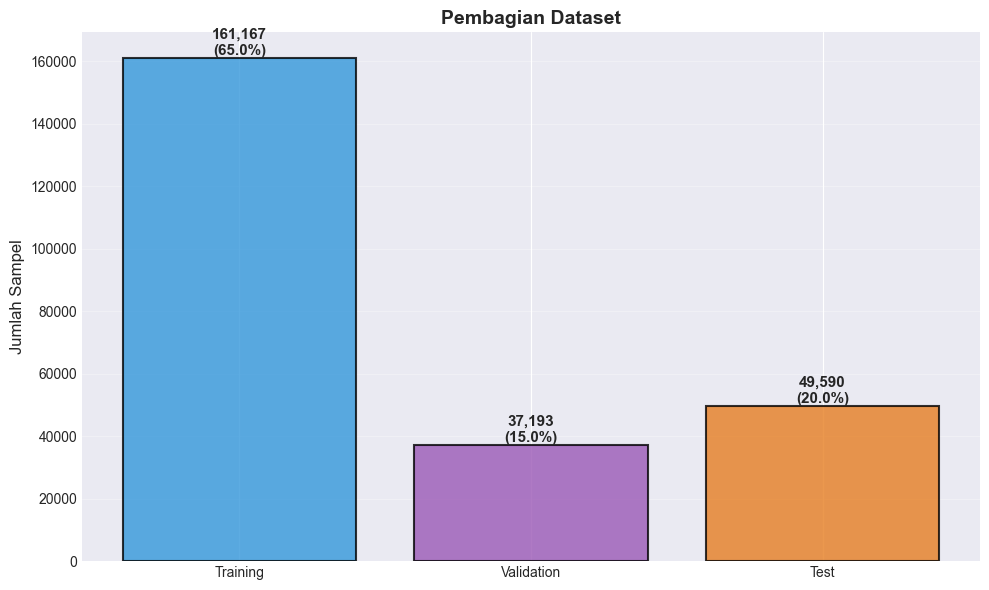

In [7]:
# Split data: Train, Validation, Test
# Pertama, pisahkan test set (20%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Kedua, pisahkan train dan validation set dari sisanya (15% dari total untuk validation)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1875, random_state=42, stratify=y_temp  # 0.1875 dari 80% = 15% dari total
)

print("="*60)
print("DATA SPLITTING")
print("="*60)
print(f"Training set: {X_train.shape[0]} sampel ({X_train.shape[0]/len(X)*100:.2f}%)")
print(f"Validation set: {X_val.shape[0]} sampel ({X_val.shape[0]/len(X)*100:.2f}%)")
print(f"Test set: {X_test.shape[0]} sampel ({X_test.shape[0]/len(X)*100:.2f}%)")

# Visualisasi pembagian data
fig, ax = plt.subplots(figsize=(10, 6))
splits = ['Training', 'Validation', 'Test']
sizes = [X_train.shape[0], X_val.shape[0], X_test.shape[0]]
colors = ['#3498db', '#9b59b6', '#e67e22']

bars = ax.bar(splits, sizes, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax.set_ylabel('Jumlah Sampel', fontsize=12)
ax.set_title('Pembagian Dataset', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Tambahkan nilai dan persentase
for bar, size in zip(bars, sizes):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{size:,}\n({size/len(X)*100:.1f}%)',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

In [8]:
# Normalisasi data menggunakan StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("="*60)
print("NORMALISASI DATA")
print("="*60)
print("Data telah dinormalisasi menggunakan StandardScaler")
print(f"\nContoh nilai sebelum normalisasi (5 sampel pertama):")
print(X_train[:5, :5])
print(f"\nContoh nilai setelah normalisasi (5 sampel pertama):")
print(X_train_scaled[:5, :5])

NORMALISASI DATA
Data telah dinormalisasi menggunakan StandardScaler

Contoh nilai sebelum normalisasi (5 sampel pertama):
[[48.  2.  0.  1.  7.]
 [29.  2.  0.  0.  7.]
 [67.  3.  0.  0. 12.]
 [87.  6.  0.  2. 21.]
 [21.  1.  0.  0.  5.]]

Contoh nilai setelah normalisasi (5 sampel pertama):
[[-0.34682636 -0.53096821 -0.44145543 -0.35170105 -0.6992954 ]
 [-0.98616719 -0.53096821 -0.44145543 -0.45605181 -0.6992954 ]
 [ 0.29251448  0.06178471 -0.44145543 -0.45605181  0.36001423]
 [ 0.96550483  1.84004346 -0.44145543 -0.24735029  2.26677158]
 [-1.25536333 -1.12372112 -0.44145543 -0.45605181 -1.12301925]]


In [9]:
# Reshape data untuk CNN-LSTM
# CNN-LSTM membutuhkan input shape: (samples, timesteps, features)
# Untuk data tabular, kita reshape ke (samples, features, 1)
X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_val_reshaped = X_val_scaled.reshape(X_val_scaled.shape[0], X_val_scaled.shape[1], 1)
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

print("="*60)
print("RESHAPE DATA UNTUK CNN-LSTM")
print("="*60)
print(f"Training shape: {X_train_reshaped.shape}")
print(f"Validation shape: {X_val_reshaped.shape}")
print(f"Test shape: {X_test_reshaped.shape}")
print(f"\nFormat: (samples, timesteps/features, channels)")
print(f"- Samples: Jumlah data")
print(f"- Timesteps: {X_train_reshaped.shape[1]} fitur")
print(f"- Channels: 1 (univariate per fitur)")

RESHAPE DATA UNTUK CNN-LSTM
Training shape: (161167, 41, 1)
Validation shape: (37193, 41, 1)
Test shape: (49590, 41, 1)

Format: (samples, timesteps/features, channels)
- Samples: Jumlah data
- Timesteps: 41 fitur
- Channels: 1 (univariate per fitur)


In [10]:
# Hitung class weights untuk menangani imbalanced data
classes = np.unique(y_train)
class_weights_array = class_weight.compute_class_weight(
    'balanced',
    classes=classes,
    y=y_train
)
class_weights_dict = dict(zip(classes, class_weights_array))

print("="*60)
print("CLASS WEIGHTS")
print("="*60)
print("Class weights digunakan untuk menangani ketidakseimbangan kelas")
for cls, weight in class_weights_dict.items():
    class_name = "Legitimate" if cls == 0 else "Phishing"
    print(f"Class {cls} ({class_name}): {weight:.4f}")

CLASS WEIGHTS
Class weights digunakan untuk menangani ketidakseimbangan kelas
Class 0 (Legitimate): 0.9645
Class 1 (Phishing): 1.0382


## 4. Membangun Model CNN + LSTM Hybrid

### Arsitektur Model:
1. **Input Layer**: Menerima data dengan shape (41 fitur, 1 channel)
2. **CNN Layers**: 
   - Conv1D Layer 1: 64 filters, ekstraksi fitur lokal
   - Conv1D Layer 2: 128 filters, ekstraksi fitur kompleks
   - Conv1D Layer 3: 256 filters, ekstraksi fitur high-level
   - MaxPooling1D: Reduksi dimensi
   - BatchNormalization: Stabilisasi training
3. **LSTM Layers**:
   - LSTM Layer 1: 128 units, menangkap dependensi sekuensial
   - LSTM Layer 2: 64 units, ekstraksi pola temporal
4. **Dense Layers**:
   - Dense 64 units dengan ReLU activation
   - Dense 32 units dengan ReLU activation
   - Dropout untuk regularisasi
5. **Output Layer**: 1 unit dengan Sigmoid activation (binary classification)

In [11]:
def build_cnn_lstm_model(input_shape):
    """
    Membangun model hybrid CNN + LSTM untuk deteksi phishing
    
    Parameters:
    -----------
    input_shape : tuple
        Shape dari input data (timesteps, features)
    
    Returns:
    --------
    model : keras.Model
        Model yang sudah dikompilasi
    """
    model = Sequential(name='CNN_LSTM_Hybrid')
    
    # ===== CNN Layers =====
    # Layer 1: Conv1D + BatchNorm + MaxPooling
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', 
                     padding='same', input_shape=input_shape, name='conv1d_1'))
    model.add(BatchNormalization(name='batch_norm_1'))
    model.add(MaxPooling1D(pool_size=2, name='maxpool_1'))
    model.add(Dropout(0.2, name='dropout_1'))
    
    # Layer 2: Conv1D + BatchNorm + MaxPooling
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', 
                     padding='same', name='conv1d_2'))
    model.add(BatchNormalization(name='batch_norm_2'))
    model.add(MaxPooling1D(pool_size=2, name='maxpool_2'))
    model.add(Dropout(0.2, name='dropout_2'))
    
    # Layer 3: Conv1D + BatchNorm
    model.add(Conv1D(filters=256, kernel_size=3, activation='relu', 
                     padding='same', name='conv1d_3'))
    model.add(BatchNormalization(name='batch_norm_3'))
    model.add(Dropout(0.3, name='dropout_3'))
    
    # ===== LSTM Layers =====
    # Layer 1: LSTM dengan return sequences
    model.add(LSTM(units=128, return_sequences=True, name='lstm_1'))
    model.add(Dropout(0.3, name='dropout_4'))
    
    # Layer 2: LSTM tanpa return sequences
    model.add(LSTM(units=64, return_sequences=False, name='lstm_2'))
    model.add(Dropout(0.3, name='dropout_5'))
    
    # ===== Dense Layers =====
    model.add(Dense(64, activation='relu', name='dense_1'))
    model.add(Dropout(0.4, name='dropout_6'))
    
    model.add(Dense(32, activation='relu', name='dense_2'))
    model.add(Dropout(0.4, name='dropout_7'))
    
    # ===== Output Layer =====
    model.add(Dense(1, activation='sigmoid', name='output'))
    
    # Compile model
    optimizer = Adam(learning_rate=0.001)
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy', 
                 keras.metrics.Precision(name='precision'),
                 keras.metrics.Recall(name='recall'),
                 keras.metrics.AUC(name='auc')]
    )
    
    return model

# Bangun model
input_shape = (X_train_reshaped.shape[1], X_train_reshaped.shape[2])
model = build_cnn_lstm_model(input_shape)

print("="*60)
print("MODEL CNN + LSTM HYBRID")
print("="*60)
model.summary()

MODEL CNN + LSTM HYBRID


Model: "CNN_LSTM_Hybrid"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)                    │ (None, 41, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_norm_1 (BatchNormalization)    │ (None, 41, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ maxpool_1 (MaxPooling1D)             │ (None, 20, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 20, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 20, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_norm_2 (BatchNormalization)    │ (None, 20, 128)             │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ maxpool_2 (MaxPooling1D)             │ (None, 10, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 10, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 10, 256)             │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_norm_3 (BatchNormalization)    │ (None, 10, 256)             │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 10, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 10, 128)             │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 10, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 378,113 (1.44 MB)

 Trainable params: 377,217 (1.44 MB)

 Non-trainable params: 896 (3.50 KB)

In [12]:
# Visualisasi arsitektur model
from tensorflow.keras.utils import plot_model

# Simpan visualisasi model
plot_model(model, to_file='model_architecture.png', 
           show_shapes=True, show_layer_names=True, 
           rankdir='TB', expand_nested=True, dpi=96)

# Tampilkan informasi layer
print("\n" + "="*60)
print("DETAIL LAYERS")
print("="*60)
for i, layer in enumerate(model.layers):
    print(f"{i+1}. {layer.name:20s} | Output Shape: {str(layer.output_shape):30s} | Params: {layer.count_params():,}")

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.

DETAIL LAYERS


AttributeError: 'Conv1D' object has no attribute 'output_shape'

## 5. Training Model dengan Callbacks

In [ ]:
# Setup callbacks untuk training
# 1. Early Stopping: Stop training jika tidak ada improvement
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1,
    mode='min'
)

# 2. Model Checkpoint: Simpan model terbaik
os.makedirs('models', exist_ok=True)
model_checkpoint = ModelCheckpoint(
    filepath='models/best_cnn_lstm_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1,
    mode='max'
)

# 3. Reduce Learning Rate: Kurangi LR saat plateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
    mode='min'
)

# 4. TensorBoard: Logging untuk visualisasi
log_dir = f"logs/fit/{datetime.now().strftime('%Y%m%d-%H%M%S')}"
os.makedirs(log_dir, exist_ok=True)
tensorboard_callback = TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    write_graph=True
)

callbacks = [early_stopping, model_checkpoint, reduce_lr, tensorboard_callback]

print("="*60)
print("CALLBACKS SETUP")
print("="*60)
print("✓ Early Stopping (patience=15)")
print("✓ Model Checkpoint (simpan model terbaik)")
print("✓ Reduce Learning Rate on Plateau (factor=0.5, patience=7)")
print("✓ TensorBoard (logging)")
print(f"\nModel akan disimpan di: models/best_cnn_lstm_model.h5")
print(f"TensorBoard logs di: {log_dir}")

In [ ]:
# Training model
print("="*60)
print("MEMULAI TRAINING")
print("="*60)
print(f"Batch size: 64")
print(f"Epochs: 100 (dengan early stopping)")
print(f"Optimizer: Adam (lr=0.001)")
print(f"Loss function: Binary Crossentropy")
print(f"Menggunakan class weights: Ya")
print("\n" + "="*60)

history = model.fit(
    X_train_reshaped, y_train,
    validation_data=(X_val_reshaped, y_val),
    epochs=100,
    batch_size=64,
    callbacks=callbacks,
    class_weight=class_weights_dict,
    verbose=1
)

print("\n" + "="*60)
print("TRAINING SELESAI!")
print("="*60)

## 6. Visualisasi Training History

In [ ]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Plot 1: Loss
axes[0, 0].plot(history.history['loss'], label='Training Loss', linewidth=2, marker='o', markersize=4)
axes[0, 0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2, marker='s', markersize=4)
axes[0, 0].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontsize=12)
axes[0, 0].legend(loc='upper right', fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Accuracy
axes[0, 1].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2, marker='o', markersize=4)
axes[0, 1].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2, marker='s', markersize=4)
axes[0, 1].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Accuracy', fontsize=12)
axes[0, 1].legend(loc='lower right', fontsize=11)
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Precision
axes[1, 0].plot(history.history['precision'], label='Training Precision', linewidth=2, marker='o', markersize=4)
axes[1, 0].plot(history.history['val_precision'], label='Validation Precision', linewidth=2, marker='s', markersize=4)
axes[1, 0].set_title('Model Precision', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('Precision', fontsize=12)
axes[1, 0].legend(loc='lower right', fontsize=11)
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Recall
axes[1, 1].plot(history.history['recall'], label='Training Recall', linewidth=2, marker='o', markersize=4)
axes[1, 1].plot(history.history['val_recall'], label='Validation Recall', linewidth=2, marker='s', markersize=4)
axes[1, 1].set_title('Model Recall', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch', fontsize=12)
axes[1, 1].set_ylabel('Recall', fontsize=12)
axes[1, 1].legend(loc='lower right', fontsize=11)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Grafik training history disimpan di: results/training_history.png")

## 7. Evaluasi Model pada Test Set

In [ ]:
# Load model terbaik
best_model = keras.models.load_model('models/best_cnn_lstm_model.h5')

# Prediksi pada test set
print("="*60)
print("EVALUASI MODEL PADA TEST SET")
print("="*60)

# Evaluasi menggunakan model.evaluate
test_results = best_model.evaluate(X_test_reshaped, y_test, verbose=1)
print("\nHasil Evaluasi Test Set:")
print(f"Test Loss: {test_results[0]:.4f}")
print(f"Test Accuracy: {test_results[1]:.4f}")
print(f"Test Precision: {test_results[2]:.4f}")
print(f"Test Recall: {test_results[3]:.4f}")
print(f"Test AUC: {test_results[4]:.4f}")

# Prediksi probabilitas
y_pred_proba = best_model.predict(X_test_reshaped)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# Hitung metrik tambahan
test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)

print("\n" + "="*60)
print("METRIK PERFORMA DETAIL")
print("="*60)
print(f"Accuracy:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Precision: {test_precision:.4f} ({test_precision*100:.2f}%)")
print(f"Recall:    {test_recall:.4f} ({test_recall*100:.2f}%)")
print(f"F1-Score:  {test_f1:.4f} ({test_f1*100:.2f}%)")

In [ ]:
# Classification Report
print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
target_names = ['Legitimate (0)', 'Phishing (1)']
print(classification_report(y_test, y_pred, target_names=target_names, digits=4))

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Visualisasi Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Confusion Matrix (nilai absolute)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, 
            xticklabels=target_names, yticklabels=target_names,
            ax=axes[0], annot_kws={'size': 14, 'weight': 'bold'})
axes[0].set_title('Confusion Matrix (Count)', fontsize=14, fontweight='bold', pad=15)
axes[0].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12, fontweight='bold')

# Plot 2: Confusion Matrix (normalized)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Greens', cbar=True,
            xticklabels=target_names, yticklabels=target_names,
            ax=axes[1], annot_kws={'size': 14, 'weight': 'bold'})
axes[1].set_title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold', pad=15)
axes[1].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('results/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Print detail confusion matrix
print("\n" + "="*60)
print("CONFUSION MATRIX DETAIL")
print("="*60)
tn, fp, fn, tp = cm.ravel()
print(f"True Negative (TN):  {tn:,} - Legitimate diprediksi Legitimate")
print(f"False Positive (FP): {fp:,} - Legitimate diprediksi Phishing")
print(f"False Negative (FN): {fn:,} - Phishing diprediksi Legitimate")
print(f"True Positive (TP):  {tp:,} - Phishing diprediksi Phishing")

print("\n✓ Confusion matrix disimpan di: results/confusion_matrix.png")

In [ ]:
# ROC Curve dan AUC Score
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=3, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=13, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=13, fontweight='bold')
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=15, fontweight='bold', pad=15)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, alpha=0.3)
plt.savefig('results/roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ ROC AUC Score: {roc_auc:.4f}")
print("✓ ROC curve disimpan di: results/roc_curve.png")

## 8. Analisis Error dan Performa Model

In [ ]:
# Visualisasi distribusi prediksi probabilitas
plt.figure(figsize=(14, 6))

# Plot untuk Legitimate URLs
plt.subplot(1, 2, 1)
legitimate_probs = y_pred_proba[y_test == 0]
plt.hist(legitimate_probs, bins=50, color='green', alpha=0.7, edgecolor='black')
plt.axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Threshold = 0.5')
plt.xlabel('Predicted Probability', fontsize=12, fontweight='bold')
plt.ylabel('Frequency', fontsize=12, fontweight='bold')
plt.title('Distribusi Probabilitas - Legitimate URLs', fontsize=13, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot untuk Phishing URLs
plt.subplot(1, 2, 2)
phishing_probs = y_pred_proba[y_test == 1]
plt.hist(phishing_probs, bins=50, color='red', alpha=0.7, edgecolor='black')
plt.axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Threshold = 0.5')
plt.xlabel('Predicted Probability', fontsize=12, fontweight='bold')
plt.ylabel('Frequency', fontsize=12, fontweight='bold')
plt.title('Distribusi Probabilitas - Phishing URLs', fontsize=13, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/probability_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Distribusi probabilitas disimpan di: results/probability_distribution.png")

In [ ]:
# Perbandingan performa pada berbagai dataset
datasets = ['Training', 'Validation', 'Test']

# Dapatkan metrik untuk setiap dataset
train_eval = best_model.evaluate(X_train_reshaped, y_train, verbose=0)
val_eval = best_model.evaluate(X_val_reshaped, y_val, verbose=0)
test_eval = best_model.evaluate(X_test_reshaped, y_test, verbose=0)

accuracies = [train_eval[1], val_eval[1], test_eval[1]]
precisions = [train_eval[2], val_eval[2], test_eval[2]]
recalls = [train_eval[3], val_eval[3], test_eval[3]]
aucs = [train_eval[4], val_eval[4], test_eval[4]]

# Visualisasi perbandingan
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
x = np.arange(len(datasets))
width = 0.6

# Plot Accuracy
bars1 = axes[0, 0].bar(x, accuracies, width, color=['#3498db', '#9b59b6', '#e67e22'], alpha=0.8, edgecolor='black')
axes[0, 0].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(datasets)
axes[0, 0].set_ylim([0, 1.1])
axes[0, 0].grid(axis='y', alpha=0.3)
for bar in bars1:
    height = bar.get_height()
    axes[0, 0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Plot Precision
bars2 = axes[0, 1].bar(x, precisions, width, color=['#3498db', '#9b59b6', '#e67e22'], alpha=0.8, edgecolor='black')
axes[0, 1].set_ylabel('Precision', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Precision Comparison', fontsize=14, fontweight='bold')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(datasets)
axes[0, 1].set_ylim([0, 1.1])
axes[0, 1].grid(axis='y', alpha=0.3)
for bar in bars2:
    height = bar.get_height()
    axes[0, 1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Plot Recall
bars3 = axes[1, 0].bar(x, recalls, width, color=['#3498db', '#9b59b6', '#e67e22'], alpha=0.8, edgecolor='black')
axes[1, 0].set_ylabel('Recall', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Recall Comparison', fontsize=14, fontweight='bold')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(datasets)
axes[1, 0].set_ylim([0, 1.1])
axes[1, 0].grid(axis='y', alpha=0.3)
for bar in bars3:
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Plot AUC
bars4 = axes[1, 1].bar(x, aucs, width, color=['#3498db', '#9b59b6', '#e67e22'], alpha=0.8, edgecolor='black')
axes[1, 1].set_ylabel('AUC', fontsize=12, fontweight='bold')
axes[1, 1].set_title('AUC Comparison', fontsize=14, fontweight='bold')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(datasets)
axes[1, 1].set_ylim([0, 1.1])
axes[1, 1].grid(axis='y', alpha=0.3)
for bar in bars4:
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('results/performance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Perbandingan performa disimpan di: results/performance_comparison.png")

## 9. Ringkasan Hasil dan Kesimpulan

In [ ]:
# Buat summary report
print("="*70)
print(" "*15 + "RINGKASAN HASIL PENELITIAN")
print("="*70)
print()
print("📊 INFORMASI DATASET")
print("-" * 70)
print(f"  • Total Sampel: {len(df):,}")
print(f"  • Jumlah Fitur: 41")
print(f"  • Kelas Legitimate: {class_counts[0]:,} ({class_counts[0]/len(df)*100:.2f}%)")
print(f"  • Kelas Phishing: {class_counts[1]:,} ({class_counts[1]/len(df)*100:.2f}%)")
print()

print("🏗️  ARSITEKTUR MODEL")
print("-" * 70)
print(f"  • Model: CNN + LSTM Hybrid")
print(f"  • Total Parameters: {model.count_params():,}")
print(f"  • CNN Layers: 3 layers (64, 128, 256 filters)")
print(f"  • LSTM Layers: 2 layers (128, 64 units)")
print(f"  • Dense Layers: 2 layers (64, 32 units)")
print(f"  • Optimizer: Adam (lr=0.001)")
print(f"  • Loss Function: Binary Crossentropy")
print()

print("📈 PERFORMA MODEL PADA TEST SET")
print("-" * 70)
print(f"  • Accuracy:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"  • Precision: {test_precision:.4f} ({test_precision*100:.2f}%)")
print(f"  • Recall:    {test_recall:.4f} ({test_recall*100:.2f}%)")
print(f"  • F1-Score:  {test_f1:.4f} ({test_f1*100:.2f}%)")
print(f"  • AUC Score: {roc_auc:.4f}")
print()

print("🎯 CONFUSION MATRIX")
print("-" * 70)
print(f"  • True Negative (TN):  {tn:,}")
print(f"  • False Positive (FP): {fp:,}")
print(f"  • False Negative (FN): {fn:,}")
print(f"  • True Positive (TP):  {tp:,}")
print()

print("💾 FILE YANG DISIMPAN")
print("-" * 70)
print(f"  • Model: models/best_cnn_lstm_model.h5")
print(f"  • Training History: results/training_history.png")
print(f"  • Confusion Matrix: results/confusion_matrix.png")
print(f"  • ROC Curve: results/roc_curve.png")
print(f"  • Probability Distribution: results/probability_distribution.png")
print(f"  • Performance Comparison: results/performance_comparison.png")
print()

print("✅ KESIMPULAN")
print("-" * 70)
print(f"  Model CNN + LSTM Hybrid berhasil mendeteksi phishing dengan:")
print(f"  - Akurasi {test_accuracy*100:.2f}% pada test set")
print(f"  - Precision {test_precision*100:.2f}% menunjukkan tingkat false positive rendah")
print(f"  - Recall {test_recall*100:.2f}% menunjukkan kemampuan deteksi phishing tinggi")
print(f"  - F1-Score {test_f1*100:.2f}% menunjukkan keseimbangan precision-recall")
print(f"  - AUC {roc_auc:.4f} menunjukkan model sangat baik dalam pemisahan kelas")
print("="*70)

## 10. Simpan Model dan Hasil

Model dan hasil visualisasi telah disimpan di folder yang sesuai untuk keperluan dokumentasi penelitian.

In [ ]:
# Simpan scaler untuk preprocessing data baru
import pickle

os.makedirs('models', exist_ok=True)
with open('models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Simpan training history
import json
history_dict = history.history
# Convert numpy values to Python native types
for key in history_dict:
    history_dict[key] = [float(x) for x in history_dict[key]]

with open('results/training_history.json', 'w') as f:
    json.dump(history_dict, f, indent=4)

# Simpan model summary ke text file
with open('models/model_summary.txt', 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))

# Simpan hasil evaluasi
results_dict = {
    'test_accuracy': float(test_accuracy),
    'test_precision': float(test_precision),
    'test_recall': float(test_recall),
    'test_f1_score': float(test_f1),
    'test_auc': float(roc_auc),
    'confusion_matrix': {
        'true_negative': int(tn),
        'false_positive': int(fp),
        'false_negative': int(fn),
        'true_positive': int(tp)
    }
}

with open('results/evaluation_results.json', 'w') as f:
    json.dump(results_dict, f, indent=4)

print("="*60)
print("SEMUA FILE BERHASIL DISIMPAN")
print("="*60)
print("✓ Model: models/best_cnn_lstm_model.h5")
print("✓ Scaler: models/scaler.pkl")
print("✓ Model Summary: models/model_summary.txt")
print("✓ Training History: results/training_history.json")
print("✓ Evaluation Results: results/evaluation_results.json")
print("\n🎉 Penelitian selesai! Model siap digunakan untuk prediksi.")